**Used cars dataset**

Giant online marketplaces like E-Bay are leveraging the growth rate of used car industy
The following report, explores Kaggle’s ‘Used Car Database’ scraped from Ebay-Kleinanzeigen (in German). 
Containing prices and attributes for approximately 370.000 second-hand cars of 40 unique brands. 
The sample contains ads that created between March 2015 and April 2016. 

It is a very messy dataset. Perfect to pratice data cleaning.
The dataset is also accompanied by another file containg a MySQL query:

    select 
     count(*) as count, 
     kilometer, 
     yearOfRegistration, 
    20*round(powerPS/20) as powerPS, 
    min(price) as minprice, 
    max(price) as maxPrice, 
    avg(price) as avgPreis, 
    sqrt(variance(price)) as sdPreis from items where 
         yearOfRegistration > 1990 and yearOfRegistration < 2016 
        and price > 100 and price < 100000 
        and powerPS < 600 and powerPS > 0 
     group by yearOfRegistration, round(powerPS/20),kilometer 
    having count > 10 
    into outfile '/tmp/cnt_km_year_powerPS_minPrice_maxPrice_avgPrice_sdPrice.csv' 
    fields terminated by ',' lines terminated by '\n';

It is an useful dataset,to pratice data cleaning, dealing with mixed data (str. and int. in the same column) 
and run some ad-hoc analysis (clustering cars, regression analysis on price,etc). Also some issues with german characters.

Disclaimer This is not a colurful presentation, I have other notebook for that. 
it is only to demonstrate though process, and achieve a clean, workable dataset.

In the second notebook, an analysis will be made, aimed at the price prediction and clustering specifics

Index:
    1.  Importing necessary packages and data
    2.  General analysis (overview of the dataset)
    3.1 Pre-processing
    3.2 Pre-processing (specific analysis)
    4.  Missing Values
    5.  Analysis of target variable 
    6.  Output file

**1 Importing necessary packages and data**

In [1]:
import numpy as np 
import pandas as pd
import re
import requests
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing
import matplotlib 
matplotlib.use('agg')
## agg backend is used to create plot as a .png file
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
autos = pd.read_csv('C:\\Users\\Marci\\Desktop\\datasets\\autos.csv',encoding = 'cp1252') #import data
autos_original = autos #for later comparison

**2 General analysis (overview of the dataset)**

In [3]:
autos.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
print('#'*40)
print('Nr. of observations,nr. of columns')
print(autos.shape) 
print('#'*40)
# Continuous Variables
print('Continuous variables')
print(autos.describe()) 

########################################
Nr. of observations,nr. of columns
(371528, 20)
########################################
Continuous variables
              price  yearOfRegistration        powerPS      kilometer  \
count  3.715280e+05       371528.000000  371528.000000  371528.000000   
mean   1.729514e+04         2004.577997     115.549477  125618.688228   
std    3.587954e+06           92.866598     192.139578   40112.337051   
min    0.000000e+00         1000.000000       0.000000    5000.000000   
25%    1.150000e+03         1999.000000      70.000000  125000.000000   
50%    2.950000e+03         2003.000000     105.000000  150000.000000   
75%    7.200000e+03         2008.000000     150.000000  150000.000000   
max    2.147484e+09         9999.000000   20000.000000  150000.000000   

       monthOfRegistration  nrOfPictures    postalCode  
count        371528.000000      371528.0  371528.00000  
mean              5.734445           0.0   50820.66764  
std               3.

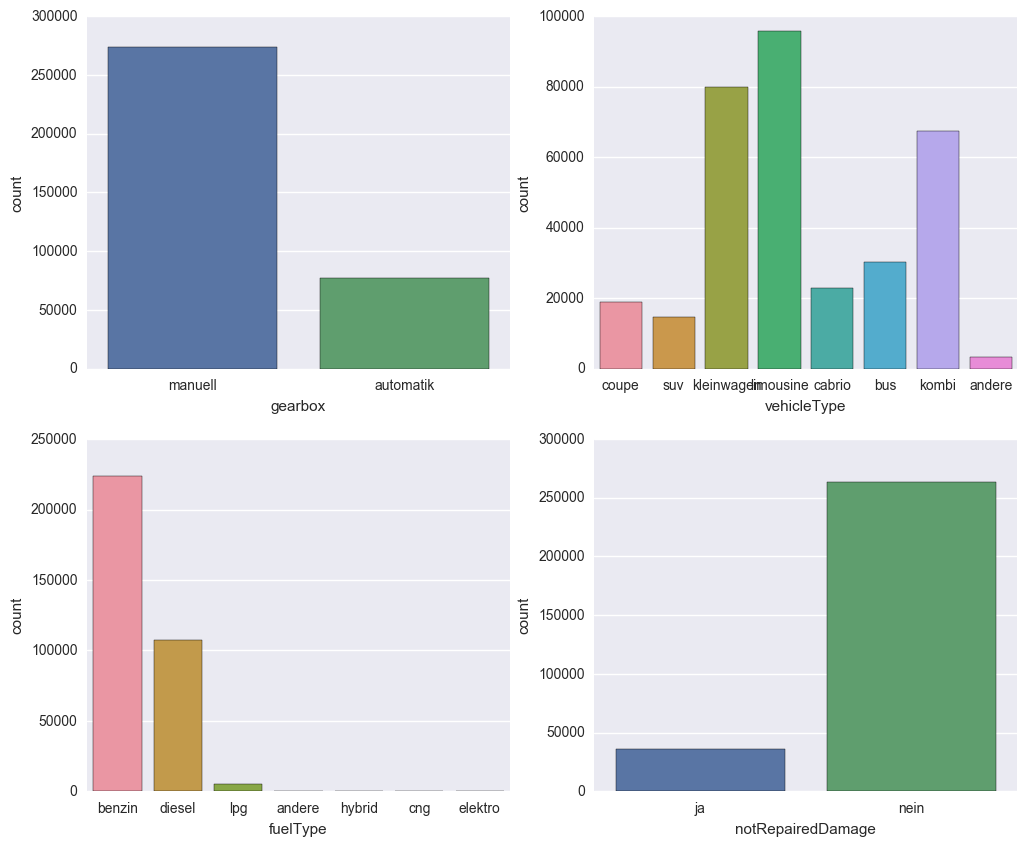

In [5]:
# Categorical Values
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.countplot(autos['gearbox'])
plt.subplot(2,2,2)
sns.countplot(autos['vehicleType'])
plt.subplot(2,2,3)
sns.countplot(autos['fuelType'])
plt.subplot(2,2,4)
sns.countplot(autos['notRepairedDamage'])
plt.show()

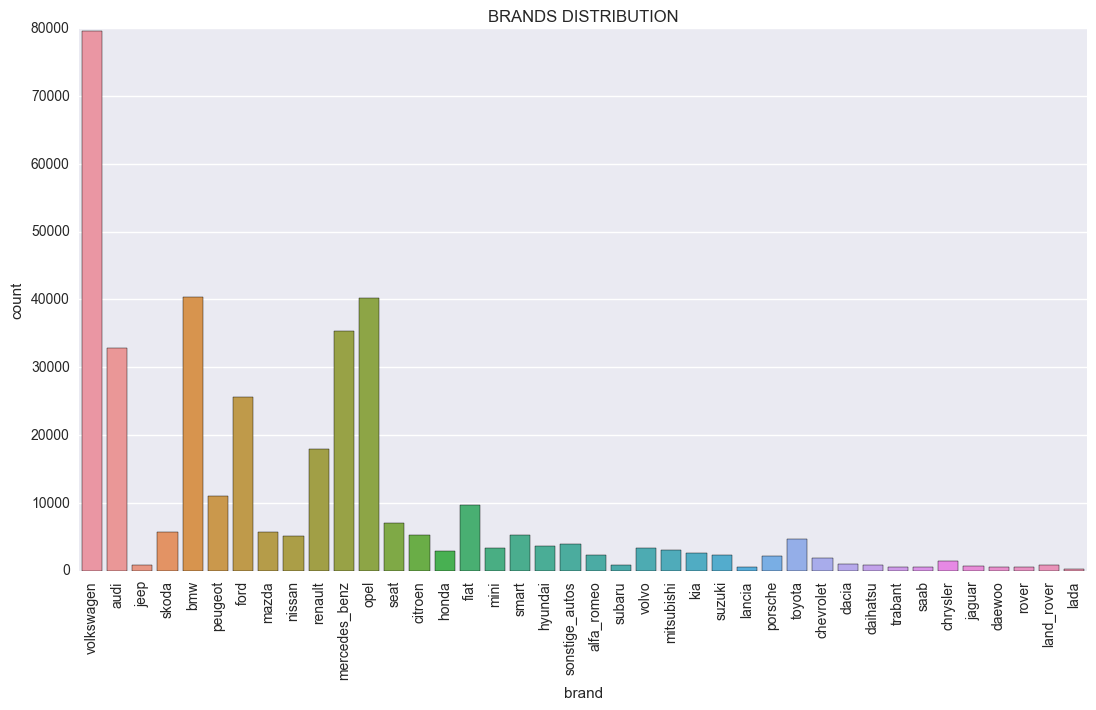

In [6]:
#brand vizualiation
sns.set_context("notebook", font_scale=1.0, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(13,7))
plt.title('BRANDS DISTRIBUTION')
g = sns.countplot(autos['brand'])
rotg = g.set_xticklabels(g.get_xticklabels(), rotation=90)

Findings:
- The dataset has a total of:
371528 observations and 20 columns.
- Some columns have no additional information, or, are irrelevant (e.g.: pictures column).
- Obvious outliers (e.g.: PowerPS and Price)
- Categorical values (particularly names need to be standardized
- Uneven distribution in the categorical values with clear predominat values (e.g. Volkswagen and manual gears)

**3.1 Pre-processing**

In [7]:
#Dropping columns with irrelevant information
autos = autos.drop('nrOfPictures',axis=1) 
autos = autos.drop('dateCrawled',axis=1) 
autos = autos.drop('lastSeen',axis=1)

#Postal is categorical information
autos['postalCode'] = autos['postalCode'].astype(str)

#separate dates and time
autos['date_Created'], autos['time_created'] = autos['dateCreated'].str.split(' ', 1).str   
autos = autos.drop('dateCreated',axis=1)

#In some continuous variables,such as price, it is safe to assume that zero is a 'missing value'
autos['price'].replace(0,np.NaN,inplace=True) 
autos['monthOfRegistration'].replace(0,np.NaN,inplace=True) 
autos['powerPS'].replace(0,np.NaN,inplace=True) 

#Cleaning outliers in continuous variables
autos = autos[(autos.yearOfRegistration >=1901) & (autos.yearOfRegistration <=2016)]  #CONVERT EVERYTHING TO THIS FORMAT
autos = autos[(autos.price > 500) & (autos.price < 1000000)]
autos.powerPS.astype('float') 
autos[autos.powerPS > 999.0] = np.NaN    #invalid field assumed as 'empty'
autos[autos.powerPS < 1.0] = np.NaN      

# Removing the duplicates
autos = autos.drop_duplicates(['name','price','vehicleType','yearOfRegistration'
                         ,'gearbox','powerPS','model','kilometer','monthOfRegistration','fuelType'
                         ,'notRepairedDamage'])

print("-----------------\nData kept for analisys: %d percent of the entire set\n-----------------" % (100 * (autos['name'].count() / autos_original['name'].count())))

-----------------
Data kept for analisys: 83 percent of the entire set
-----------------


**3.2 Pre-processing (specific analysis)**

In [8]:
# Analysis of 'name' column
autos.name.head(20)

1                                  A5_Sportback_2.7_Tdi
2                        Jeep_Grand_Cherokee_"Overland"
3                                    GOLF_4_1_4__3TÜRER
4                        Skoda_Fabia_1.4_TDI_PD_Classic
5     BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...
6                           Peugeot_206_CC_110_Platinum
8                  Ford_C___Max_Titanium_1_0_L_EcoBoost
9     VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...
10                                    Mazda_3_1.6_Sport
11        Volkswagen_Passat_Variant_2.0_TDI_Comfortline
12                    VW_Passat_Facelift_35i__"7Sitzer"
13                       VW_PASSAT_1.9_TDI_131_PS_LEDER
14    Nissan_Navara_2.5DPF_SE4x4_Klima_Sitzheizg_Blu...
17                          Renault_Twingo_1.2_16V_Aut.
18                     Ford_C_MAX_2.0_TDCi_DPF_Titanium
19                    Mercedes_Benz_A_160_Classic_Klima
20                    Volkswagen_Scirocco_1.4_TSI_Sport
21    BMW_530i_TÜV_7/17_Scheckheftgepflegt_sehr_

From above, we see lots of special caracheters and expressions , that should be removed. E.g: !!!, '_', caps lock descriptions,...
The fields 'name' and 'model' should be normalized (using NLTK principles). 
The idea, is to retrieve the 'model' from the 'name' discrition, in case of missing value or, conflicting data.

In [9]:
#"_" is often used as a space therefore will be treated seperately
autos['name'] = autos['name'].astype(str) #str to avoid conflict with german characters
autos['name'] = autos['name'].str.replace("_",' ')
tokenizer = RegexpTokenizer(r'\w+')
for item in autos['name']:
    tokenizer.tokenize(item)  

#tokenize(), misses certain cases (source: http://www.nltk.org/book/ch03.html)   
#regex for remaining cases with the special characters/cases
autos['name'] = autos['name'].str.replace('.','')
autos['name'] = autos['name'].str.replace('  ',' ')
autos['name'] = autos['name'].str.replace('"','')
autos['name'] = [w.lower() for w in autos['name']] 
print(autos.name.head(20)) #much cleaner

1                                   a5 sportback 27 tdi
2                          jeep grand cherokee overland
3                                     golf 4 1 4 3türer
4                         skoda fabia 14 tdi pd classic
5       bmw 316i  e36 limousine  bastlerfahrzeug export
6                           peugeot 206 cc 110 platinum
8                   ford c  max titanium 1 0 l ecoboost
9     vw golf 4 5 tuerig zu verkaufen mit anhaengerk...
10                                     mazda 3 16 sport
11         volkswagen passat variant 20 tdi comfortline
12                       vw passat facelift 35i 7sitzer
13                        vw passat 19 tdi 131 ps leder
14    nissan navara 25dpf se4x4 klima sitzheizg blue...
17                            renault twingo 12 16v aut
18                      ford c max 20 tdci dpf titanium
19                    mercedes benz a 160 classic klima
20                     volkswagen scirocco 14 tsi sport
21    bmw 530i tüv 7/17 scheckheftgepflegt sehr 

In [10]:
# Analysis of 'model' column
len(set(autos.model.unique())) #there was 'nan' model (nan can also mean empty)
print(autos[autos.model == 'nan'].std()['price']) #this proves the theory above that 'NaN'(as string and not NA) is 
                                                    #an invalid 'model' input
autos[autos.model == 'nan'] = np.NaN

# Normalizing 'model' column
autos['model'] = autos['model'].str.replace("_",' ')
tokenizer = RegexpTokenizer(r'\w+')
for item in autos['model']: 
    tokenizer.tokenize(str(item))
#cleaning the remaining cases    
autos['model'] = autos['model'].str.replace('.','')
autos['model'] = autos['model'].str.replace('  ',' ')
autos['model'] = autos['model'].str.replace('"','')
autos.model.str.lower()

nan


1                 NaN
2               grand
3                golf
4               fabia
5                 3er
6             2 reihe
8               c max
9                golf
10            3 reihe
11             passat
12             passat
13             passat
14             navara
17             twingo
18              c max
19           a klasse
20           scirocco
21                5er
25                5er
27              civic
28        transporter
29              punto
30           e klasse
31               clio
33                3er
34           e klasse
36             kadett
37             kangoo
38             andere
39             andere
             ...     
371496        2 reihe
371497          astra
371498         vectra
371499          corsa
371500           golf
371501        voyager
371502             a4
371503          justy
371504       c klasse
371505          astra
371506           golf
371507             a4
371508          astra
371509            NaN
371510    

In the cases below both the column 'seller' and 'offerType' are deleted.
Due to little to none, relevant infomartion. 
Hence these should be treated as outliers, and defeat the purpose of anlaysis

In [11]:
print(autos.groupby('seller').size())
autos = autos.drop('seller', 1) #drop 'seller' (only 3 instances'gewerblich' in the whole dataset)
print(30*'#')
print(autos.groupby('offerType').size())
autos = autos.drop('offerType', 1) #drop 'offerType' instances (only 12 instances 'Gesuch')

seller
gewerblich         2
privat        308713
dtype: int64
##############################
offerType
Angebot    308710
Gesuch          5
dtype: int64


**4. Missing Values**

In [12]:
autos.isnull().sum()

name                       0
price                      1
abtest                     1
vehicleType            13417
yearOfRegistration         1
gearbox                10716
powerPS                23798
model                  13079
kilometer                  1
monthOfRegistration    20528
fuelType               17848
brand                      1
notRepairedDamage      46746
postalCode                 1
date_Created               1
time_created               1
dtype: int64

When imputing missing values, one could search for patterns or rules of thumb to fill NAs.

In dataset a combination of same models and brand, should have the same categorical characteristics, or at least a predominant mode.
Therfore there are two possible approaches: 
      - fill.na using the mode, or: 
      - fill in with 'non-declared'. 
with the lastest one, being a standard pratice in e-commerce, as not declaring all characteristics afects the value of the sale

In [13]:
#Missing values: 'model'
temporary = autos.model.astype('str')
models_list = temporary.unique().tolist()
models =  re.compile(r'\b(?:%s)\b' % '|'.join(models_list))
for i,row in autos.loc[autos['model'].isnull(),:].iterrows():
    if  re.search(models,autos.loc[i,'name']) != None:
        autos.loc[i,'model'] = re.search(models,autos.loc[i,'name']).group()  
autos['model'] = autos['model'].fillna('non-declared')  # fill remaining NAs
        
# Missing Values: 'powerPS'
print(autos.groupby(['yearOfRegistration','model']).std()['powerPS'].mean()) #the diviation is small, imputation can be applied
autos['powerPS'] = autos.groupby(['yearOfRegistration','brand','model']).transform(lambda x: x.fillna(x.mean()))['powerPS']

# Missing values: 'notRepairedDamage'
print(autos.groupby('notRepairedDamage').size())
autos['notRepairedDamage'] = autos['notRepairedDamage'].fillna('non-declared')  

# Missing Values: 'gearbox' & 'fuelType'
autos[(autos.gearbox =='automatik')]['fuelType'] = 'elektro'  
autos[(autos.fuelType =='elektro')]['gearbox'] = 'automatik'

autos['fuelType'] = autos['fuelType'].fillna('non-declared')
autos['gearbox'] = autos['gearbox'].fillna('non-declared')

# Missing Values: 'vehicleType'     
autos['vehicleType'] = autos['vehicleType'].fillna('non-declared')

26.48571059689719
notRepairedDamage
ja       23672
nein    238298
dtype: int64


C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Marci\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
#improvements
print('model, nr. of NAs solved:',autos_original.model.isnull().sum() - autos.model.isnull().sum())
print('powerPS, nr. of NAs solved:',autos_original.powerPS.isnull().sum() - autos.powerPS.isnull().sum())
print('notRepairedDamage, nr. of NAs solved:',autos_original.notRepairedDamage.isnull().sum() - autos.notRepairedDamage.isnull().sum())
print('gearbox, nr. of NAs solved:',autos_original.gearbox.isnull().sum() - autos.gearbox.isnull().sum())
print('fuelType, nr. of NAs solved:',autos_original.fuelType.isnull().sum() - autos.fuelType.isnull().sum())
print('vehicleType, nr. of NAs solved:',autos_original.vehicleType.isnull().sum() - autos.vehicleType.isnull().sum())
autos.isnull().sum()

model, nr. of NAs solved: 20484
powerPS, nr. of NAs solved: -507
notRepairedDamage, nr. of NAs solved: 72060
gearbox, nr. of NAs solved: 20209
fuelType, nr. of NAs solved: 33386
vehicleType, nr. of NAs solved: 37869


name                       0
price                      1
abtest                     1
vehicleType                0
yearOfRegistration         1
gearbox                    0
powerPS                  507
model                      0
kilometer                  1
monthOfRegistration    20528
fuelType                   0
brand                      1
notRepairedDamage          0
postalCode                 1
date_Created               1
time_created               1
dtype: int64

In [15]:
#Preparing & cleaning the for visualizations and predictions
autos.drop('monthOfRegistration',axis=1)
autos.dropna()
# A small feature engineering: Count of 'non-declared' variables
#Hypothesis: the less specified is an advertisement, the smaller is the value
autos['non-declared'] = autos.isnull().sum(axis=1)

**5. Target variable analysis**

This subset of 'super expensive' cars is very dirty, and rather small, we don't have enough observation to make significant sample

nr of cars above 100k: 403


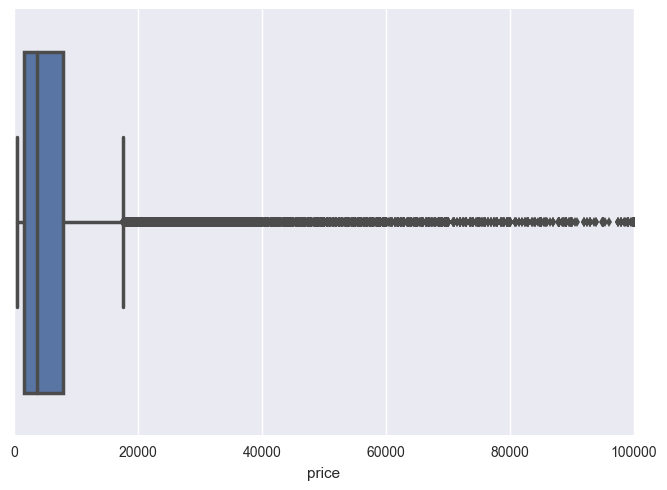

C:\Users\Marci\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


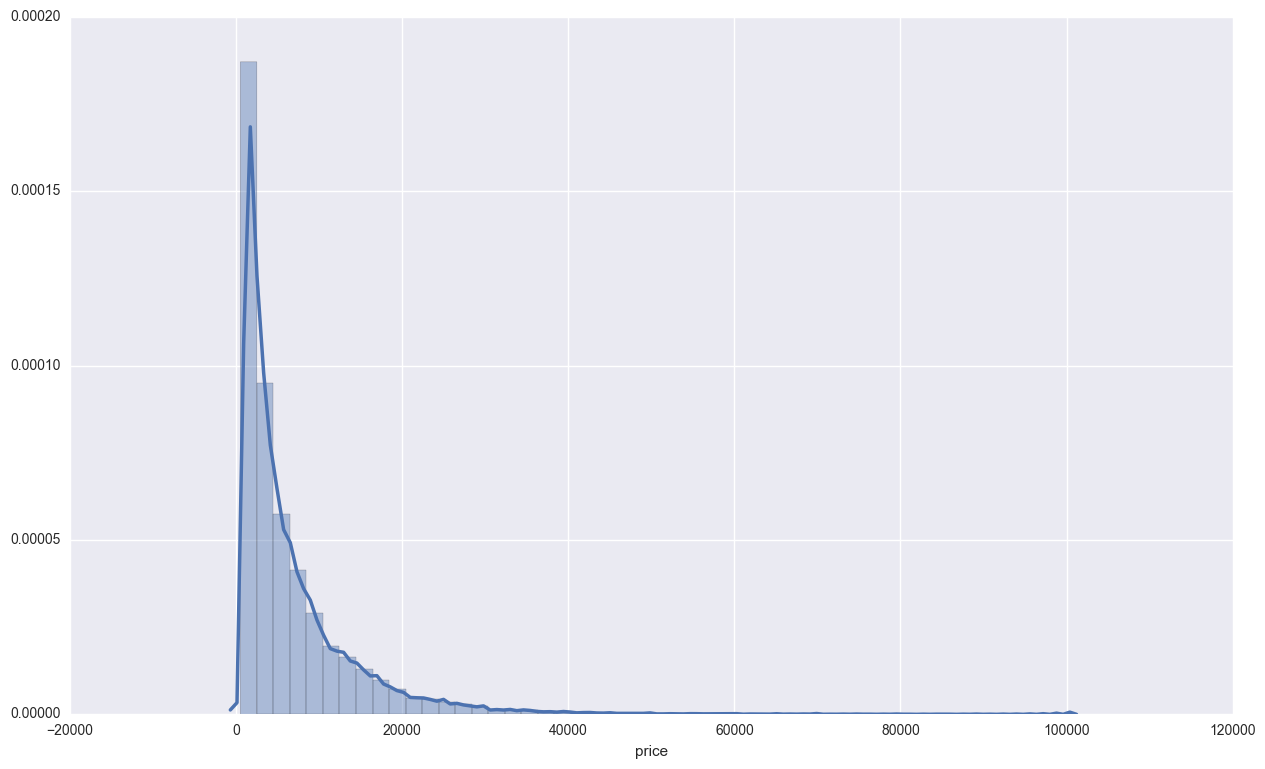

skewness of price distribution: 3.41827873052


In [16]:
#let see a boxplot for price
autos_expensive = autos_original[(autos_original.price > 100000)]
print('nr of cars above 100k:',autos_expensive.price.count())

autos = autos[(autos.price < 100000)]

sns.boxplot(autos['price'])
sns.plt.show()

plt.subplots(figsize=(15,9))
sns.distplot(autos['price'])
sns.plt.show()
print('skewness of price distribution:',autos['price'].skew()) #the distribution is skewed to the left

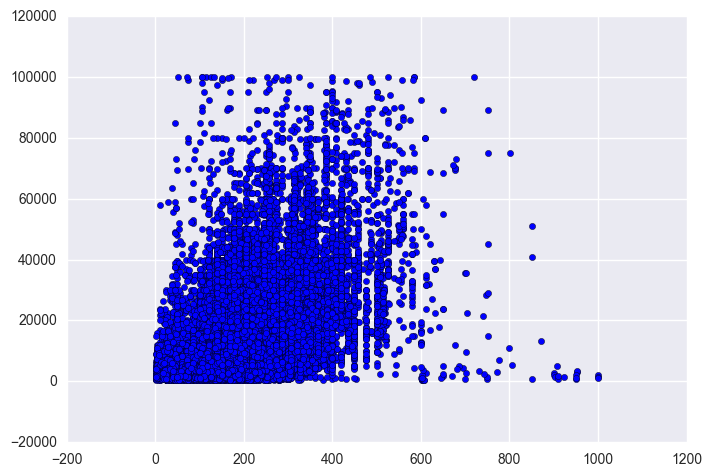

In [17]:
#Searching for more outliers
plt.clf()
plt.scatter(autos['powerPS'],autos['price'])

autos = autos[autos.powerPS < 850.0] # removing the outliers on the fight hand side(e.g. 850PS with almost price zero

In [18]:
# Preparation of categorical features for analysis (aka: one-hot encoding)
labels = ['gearbox', 'notRepairedDamage', 'model', 'brand', 'fuelType', 'vehicleType','postalCode','abtest','non-declared']
les = {}

for l in labels:
    les[l] = preprocessing.LabelEncoder()
    les[l].fit(autos[l].astype(str))
    tr = les[l].transform(autos[l].astype(str)) 
    autos.loc[:, l + '_feat'] = pd.Series(tr, index=autos.index)

autos_oneHot = autos[ ['price'
                        ,'yearOfRegistration'
                        ,'powerPS'
                        ,'kilometer'] 
                    + [x+"_feat" for x in labels]]

price                     1.000000
powerPS                   0.571337
yearOfRegistration        0.359293
postalCode_feat           0.070803
fuelType_feat             0.046484
abtest_feat               0.001389
model_feat               -0.003401
vehicleType_feat         -0.006888
notRepairedDamage_feat   -0.029400
non-declared_feat        -0.107123
brand_feat               -0.109304
gearbox_feat             -0.291674
kilometer                -0.439877
Name: price, dtype: float64

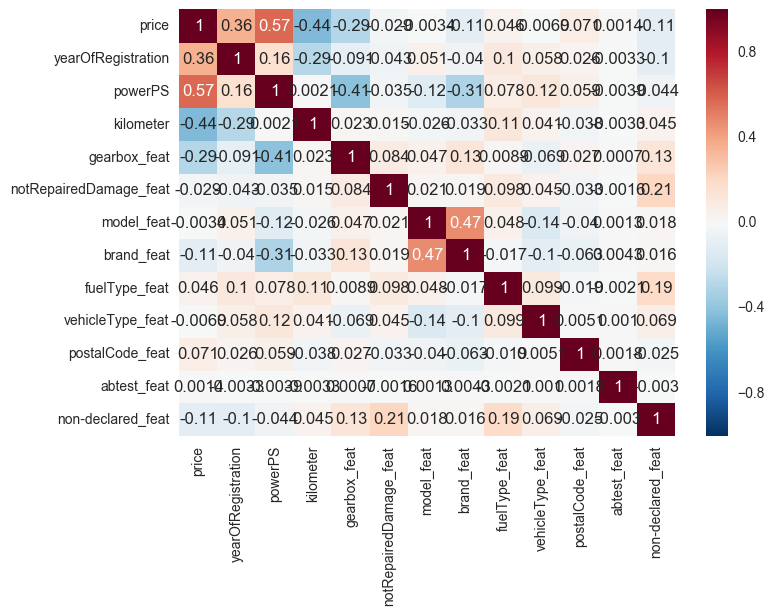

In [19]:
# Correlations with target variable
sns.heatmap(autos_oneHot.corr(), annot=True)
corr=autos_oneHot.corr()["price"]
corr[np.argsort(corr, axis=0)[::-1]]

**6. Price Prediction**

C:\Users\Marci\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


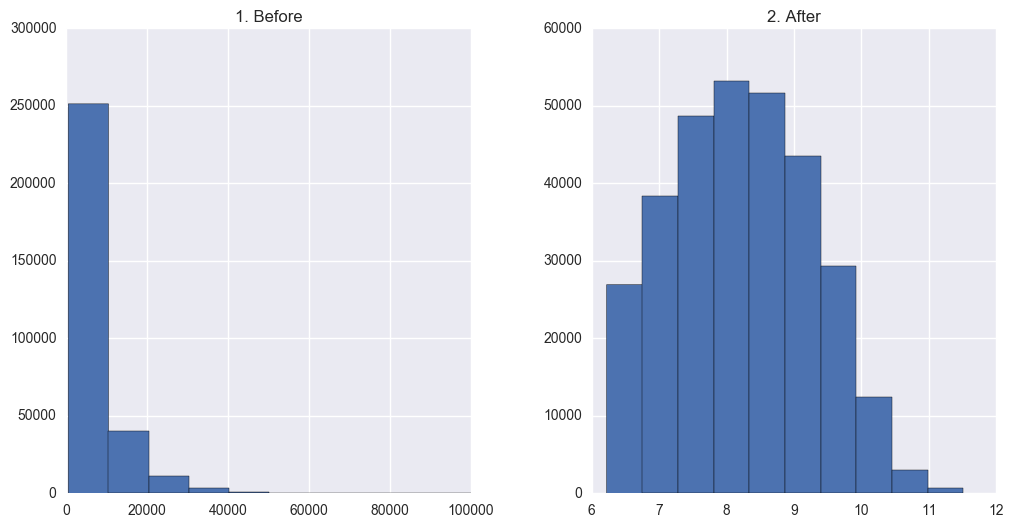

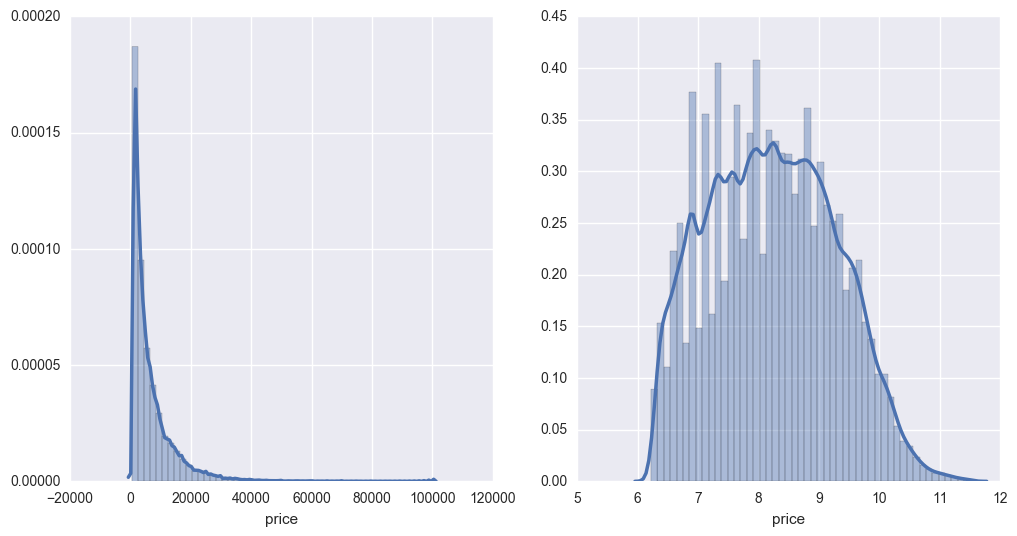

In [23]:
# Serating the target variable (price)
y = autos_oneHot['price']
X = autos_oneHot.drop(['price'], axis='columns', inplace=False)

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"1. Before":y, "2. After":np.log1p(y)})
prices.hist()

# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False)
before = sns.distplot(y, ax=ax1, label = 'before')
after = sns.distplot(np.log1p(y), ax=ax2, label ='after')

# Feature engineering: price
y = np.log1p(y) #transforming the price to exp. form

In [24]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
X_tr.shape,y_tr.shape,X_test.shape, y_test.shape

((215503, 12), (215503,), (92359, 12), (92359,))

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
rf = RandomForestRegressor()
tuned_parameters = {'n_estimators': [500],
              'max_depth':[10],
              'min_samples_split':[3],
              'min_samples_leaf':[3],
             'random_state':[0]}
clf = GridSearchCV(rf, tuned_parameters, cv=2, n_jobs=-1, verbose=1)  
clf.fit(X_tr,y_tr)



print(clf.best_score_)
print(clf.best_params_)

model=RandomForestRegressor(max_depth= 10, min_samples_leaf= 3,min_samples_split= 3, n_estimators= 500,random_state= 0)
model.fit(X_tr,y_tr)
model.score(X_test,y_test)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.1min finished


0.832269262569
{'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 500, 'random_state': 0, 'max_depth': 10}


0.83469562038129885

In [26]:
model.feature_importances_   #Next, put this on a graph

array([  6.19530797e-01,   2.56630248e-01,   4.31644865e-02,
         1.29519456e-03,   1.75549366e-02,   8.62749578e-03,
         1.79601256e-02,   1.38082951e-03,   3.18737593e-02,
         1.40808714e-03,   1.19974814e-04,   4.54065085e-04])

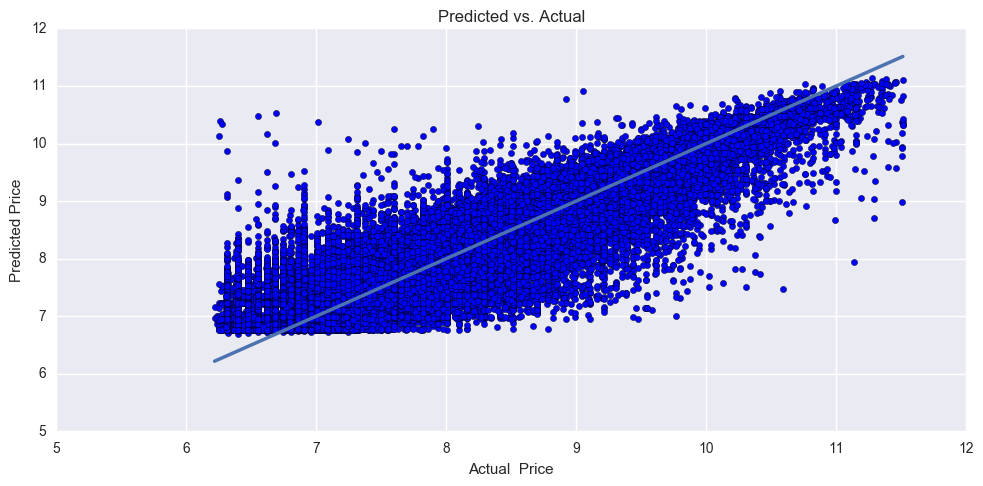

In [28]:
y_pred= model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual  Price')
plt.ylabel('Predicted Price')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)])
plt.tight_layout()

**7. Conclusions**
    - Model imputation proved to be a big winner: over 10000 NAs soilved by comparing with the name feature
    - Horse Power is the biggest component of price, followed by yearOFregistration, km, gearbox and brand
    - There is some co-linearity between kilometers and yearOFregistration, feature engineering might be a nice     
      addition to have.
    - The model feature doesn't appear to have lot's of strengh, perhaps due to the fact that the same model may be     
      present in different brands (e.g. series 1)  
    - Data cleaning is a never ending job. The beauty of working with very poor datasets, 
      is no matter how far you have gone, it is always possible to improve.

In [29]:
#saving output file
autos_oneHot.to_csv('C:\\Users\\Marci\\Desktop\\datasets\\autos_output.csv', index=False)

In [30]:
#inspirations: https://www.analyticsvidhya.com/blog/2016/01/12-pandas-techniques-python-data-manipulation/
#http://stackoverflow.com/questions/3040716/python-elegant-way-to-check-if-at-least-one-regex-in-list-matches-a-string
#http://stackoverflow.com/questions/17679089/pandas-dataframe-groupby-two-columns-and-get-counts
#Food for thought:Knn imputation might be an alternative solution

¯\_(ツ) _/¯ Happy coding!